In [ ]:
%%capture
!pip install pyro-ppl
!pip install arviz

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz
from copy import deepcopy

from tqdm.notebook import tqdm

# B Function fitting

## B.1 Fitting a GP with Pyro

In [ ]:
pyro.clear_param_store()
pyro.set_rng_seed(13)
N = 5

x = torch.linspace(-1, 1, N)
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)

y = f(x)

kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))

gpr = gp.models.GPRegression(x, y, kernel, noise=torch.tensor(1e-4))

In [ ]:
nuts_kernel = NUTS(gpr.model, target_accept_prob = 0.95, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=4, warmup_steps=2000, mp_context="spawn")
mcmc.run()

/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/2500 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:300: UserWarning: operator() profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Warmup:   0%|          | 0/2500 [00:

### Deliverable B1-1

In [ ]:
sigma_l, sigma_s = mcmc.get_samples().values()

In [ ]:
from scipy.stats import gaussian_kde

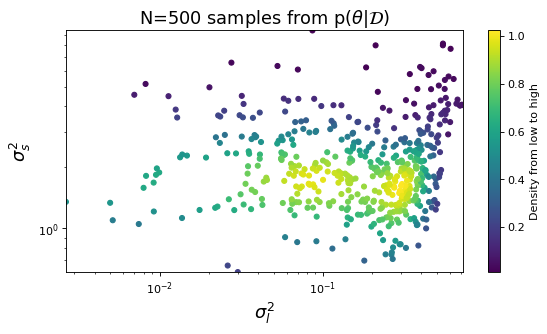

In [ ]:
# Calculate the point density
xy = np.vstack([sigma_l[:500],sigma_s[:500]])
z = gaussian_kde(xy, bw_method="scott")(xy)

plt.figure(figsize=(8,4), dpi=80)

sc = plt.scatter(sigma_l[:500], sigma_s[:500], c = z, s=20)
plt.colorbar(sc, label='Density from low to high')


plt.xlim(min(sigma_l[:500]), max(sigma_l[:500]))
plt.ylim(min(sigma_s[:500]), max(sigma_s[:500]))


plt.title("N=500 samples from p($\\theta$|$\mathcal{D})$", fontsize=16)
plt.xlabel("$\sigma_l^2$", fontsize=16)
plt.ylabel("$\sigma_s^2$", fontsize=16)

plt.xscale("log")
plt.yscale("log")

### Delivarable B.1.2

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.245  0.158   0.003    0.502      0.008    0.005   
kernel.variance     2.337  1.500   0.636    4.598      0.079    0.059   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     426.0     693.0   1.02  
kernel.variance        485.0     440.0   1.01  


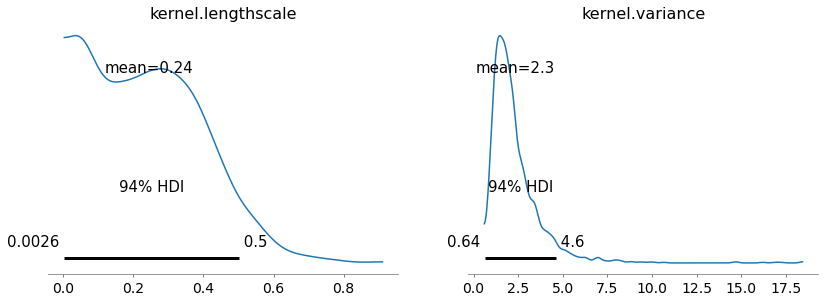

In [ ]:
data = arviz.from_pyro(mcmc)

summary = arviz.summary(data)
print(summary)

arviz.plot_posterior(data)
plt.show();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa057cc9a0>,
      dtype=object)

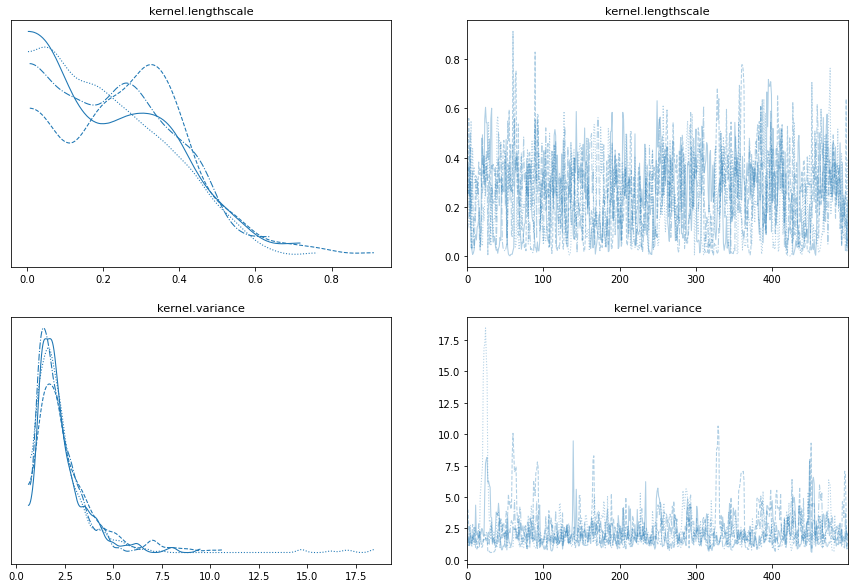

In [ ]:
arviz.plot_trace(data, figsize=(15, 10))

### Delivarable B.1.3

In [ ]:
samples = mcmc.get_samples()

In [ ]:
mean_list = []
var_list = []

# Iterate through the samples
for i in range(mcmc.num_samples):
    # Update kernel and noise parameters with the current sample
    kernel.variance = samples['kernel.variance'][i]
    kernel.lengthscale = samples['kernel.lengthscale'][i]

    # Compute the mean and variance of the predictions at new points x_new
    mean, cov = gpr(torch.linspace(-1, 1, 200), full_cov=True)
    mean_list.append(mean)
    var_list.append(cov)

# Compute the posterior mean and variance of the predictions
post_mean = torch.mean(torch.stack(mean_list), dim=0)
post_var = torch.mean(torch.stack(var_list), dim=0)
orig_post_mean = torch.clone(post_mean)
orig_post_var = torch.clone(post_var)

In [ ]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    kernel=None,
    n_test=200,
    ax=None,
    use_new_points=False,
    sample_plot=None,
    use_other_title=None,
    use_summer_gradient=False
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_predictions:
        Xtest = np.linspace(-1, 1, n_test)  # test inputs
        y_real = f(torch.linspace(-1.0, 1.0, n_test))
        # compute predictive mean and variance
        mean = post_mean.detach().cpu() 
        sd = post_var.detach().cpu().diag().sqrt()

        #sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest, mean.numpy(), "r", label='$m(x^*)$')  # plot the mean
        ax.plot(Xtest, y_real.numpy(), 'k', label='$f(x^*)$')
        if sample_plot is not None:
            ax.plot(Xtest, sample_plot.numpy(), "grey", ls='--', label="$f^*(x^*)$")
        ax.fill_between(
            Xtest,  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
            label='$m(x^*) \pm 2\sigma$'
        )
    ax.set_xlim(-1.0, 1.0)
    ax.set_xlabel("$x^*$")
    if plot_observed_data:
        ax.scatter(x.numpy(), y.numpy(), s=100, c='k', marker='o', label=r'$\mathcal{D}$')
        
        if use_new_points:
            
            if use_summer_gradient:
                col_len = len(np.array(D_x)[5:])
                colors = matplotlib.cm.summer(np.linspace(0, 1, 10))[:col_len]
            else:
                colors = 'lime'
            ax.scatter(np.array(D_x)[5:], np.array(D_y)[5:], s=100, c=colors, marker='o', label=r'$(x^*_p, f(x^*_p))$')
            
    ax.legend(loc=4)
    ax.set_ylabel('$f$')
    ax.set_title('Visualization of $p(f^*|x^*, \mathcal{D})$', fontsize=20)
    if use_other_title is not None:
        ax.set_title(use_other_title, fontsize=20)

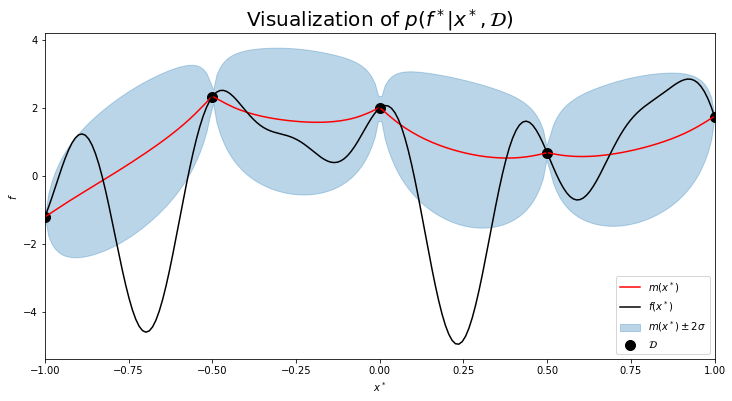

In [ ]:
plot(plot_observed_data=True, plot_predictions=True)

## B.2 Bayesian Optimization

### Delivarable B.2.1

In [ ]:
X_star = torch.linspace(-1.0, 1.0, 200)
T = 10

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [ ]:
D_x = x.tolist()
D_y = y.tolist()

In [ ]:
# sample from new distribution
m = MultivariateNormal(post_mean, post_var)
samples = m.sample()
samples += dist.Normal(0.0, 1e-8).sample(sample_shape=(200,))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))
plot(plot_observed_data=True, plot_predictions=True, use_new_points=True, ax=ax1, sample_plot=samples, use_other_title='$k=0$')

for k in tqdm(range(T)):
    # create gpr and set kernel hyperparameters
    pyro.clear_param_store()

    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
    kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))

    gpr = gp.models.GPRegression(torch.tensor(D_x), torch.tensor(D_y), kernel, noise=torch.tensor(1e-4))
    # run MCMC with NUTS
    nuts_kernel = NUTS(gpr.model, jit_compile=True)
    mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=1, warmup_steps=500)
    mcmc.run()

    mean_list = []
    var_list = []

    # Calculate posterior predictive using MC 
    samples = mcmc.get_samples()
    mean_list = []
    var_list = []

    for i in range(mcmc.num_samples):

        kernel.variance = samples['kernel.variance'][i]
        kernel.lengthscale = samples['kernel.lengthscale'][i]


        mean, cov = gpr(torch.linspace(-1, 1, 200), full_cov=True, noiseless=False)
        mean_list.append(mean)
        var_list.append(cov)

    post_mean = torch.mean(torch.stack(mean_list), dim=0)
    post_var = torch.mean(torch.stack(var_list), dim=0)


    # sample from new distribution
    m = MultivariateNormal(post_mean, post_var)
    samples = m.sample()
    samples += dist.Normal(0.0, 1e-8).sample(sample_shape=(200,))

    if k == 4:
        plot(model=gpr, plot_observed_data=True, plot_predictions=True, use_new_points=True, 
             ax=ax2, sample_plot=samples, use_other_title='$k=5$')
    if k == 9:
        plot(model=gpr, plot_observed_data=True, plot_predictions=True, use_new_points=True, 
             ax=ax3, sample_plot=samples, use_other_title='$k=10$')
        

    p = torch.argmin(samples)
    D_x.append(X_star[p].item())
    D_y.append(f(X_star[p]).item())

print(D_x, D_y)

### B.2.2

In [ ]:
D_x = x.tolist()
D_y = y.tolist()

In [ ]:
T = 10

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for k in tqdm(range(T)):
    # create gpr and set kernel hyperparameters
    pyro.clear_param_store()


    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
    kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))

    gpr = gp.models.GPRegression(torch.tensor(D_x), torch.tensor(D_y), kernel, noise=torch.tensor(1e-4))
    # run MCMC with NUTS
    nuts_kernel = NUTS(gpr.model, jit_compile=True)
    mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=1, warmup_steps=500)
    mcmc.run()

    mean_list = []
    var_list = []

    # Calculate posterior predictive using MC 
    samples = mcmc.get_samples()
    mean_list = []
    var_list = []

    for i in range(mcmc.num_samples):

        kernel.variance = samples['kernel.variance'][i]
        kernel.lengthscale = samples['kernel.lengthscale'][i]


        mean, cov = gpr(torch.linspace(-1, 1, 200), full_cov=True, noiseless=False)
        mean_list.append(mean)
        var_list.append(cov)

    post_mean = torch.mean(torch.stack(mean_list), dim=0)
    post_var = torch.mean(torch.stack(var_list), dim=0)


    # sample from new distribution
    m = MultivariateNormal(post_mean, post_var)
    samples = m.sample()
    samples += dist.Normal(0.0, 1e-8).sample(sample_shape=(200,))

    print(X_star[p].item())
    p = torch.argmin(samples)
    D_x.append(X_star[p].item())
    D_y.append(f(X_star[p]).item())

plot(model=gpr, plot_observed_data=True, plot_predictions=True, use_new_points=True, ax=ax, sample_plot=samples, use_other_title='$k=10$')
print(D_x, D_y)

### Delivarables B.2.3

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.cm as cm
from matplotlib.colors import Normalize
norm = Normalize(vmin=1, vmax=10)

In [ ]:
# sample from new distribution
m = MultivariateNormal(post_mean, post_var)
samples = m.sample()
samples += dist.Normal(0.0, 1e-8).sample(sample_shape=(200,))

orig_samples = deepcopy(samples)

In [ ]:
X_star = torch.linspace(-1.0, 1.0, 200)
T = 10

In [ ]:
D_x = x.tolist()
D_y = y.tolist()

In [ ]:
samples = orig_samples
post_mean = orig_post_mean
post_var = orig_post_var

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))

plot(plot_observed_data=True, plot_predictions=True, ax=ax1, sample_plot=samples, use_other_title='$k=0$')

for k in tqdm(range(T)):
    # create gpr and set kernel hyperparameters
    pyro.clear_param_store()

    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
    kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))

    gpr = gp.models.GPRegression(torch.tensor(D_x), torch.tensor(D_y), kernel, noise=torch.tensor(1e-4))
    # run MCMC with NUTS
    nuts_kernel = NUTS(gpr.model, jit_compile=True, max_tree_depth=5) #target_accept_prob = 0.925
    mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=1, warmup_steps=100, mp_context="spawn")
    mcmc.run()

    # Calculate posterior predictive using MC 
    samples = mcmc.get_samples()
    mean_list = []
    var_list = []

    for i in range(mcmc.num_samples):

        kernel.variance = samples['kernel.variance'][i]
        kernel.lengthscale = samples['kernel.lengthscale'][i]


        mean, cov = gpr(torch.linspace(-1, 1, 200), full_cov=True, noiseless=False)
        mean_list.append(mean)
        var_list.append(cov)

    post_mean = torch.mean(torch.stack(mean_list), dim=0)
    post_var = torch.mean(torch.stack(var_list), dim=0)


    # sample from new distribution
    m = MultivariateNormal(post_mean, post_var)
    samples = m.sample()
    samples += dist.Normal(0.0, 1e-8).sample(sample_shape=(200,))

    if k == 4:
        plot(plot_observed_data=True, plot_predictions=True, use_new_points=True, 
             ax=ax2, sample_plot=samples, use_other_title='$k=5$', use_summer_gradient=True)
    if k == 9:
        plot(plot_observed_data=True, plot_predictions=True, use_new_points=True, 
             ax=ax3, sample_plot=samples, use_other_title='$k=10$', use_summer_gradient=True)
        
    # LCB
    beta = torch.tensor(1.5)
    samples -= torch.sqrt(beta) * post_var.diag().sqrt()

    p = torch.argmin(samples)
    print(X_star[p].item())
    D_x.append(X_star[p].item())
    D_y.append(f(X_star[p]).item())

fig.colorbar(cm.ScalarMappable(norm=norm, cmap="summer"), ax=ax3)
print(D_x, D_y)